In [6]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import learn2learn as l2l
from models import SIREN
from tqdm import tqdm
import os
from icecream import ic

import config

config.set_status("t-sne")

# Assume models are saved in a list of file paths
group_name = "earthquake_default"

ind = 1
model_paths = []
while os.path.exists(config.model_dir + f'{group_name}/eval_{ind}.pth'):
    model_paths.append(config.model_dir + f'{group_name}/eval_{ind}.pth')
    ind += 1
    # if ind >= 270:
    #     break


config.seed_everything(43)

# Function to extract features
def extract_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

# Collect all features
all_weights = []

for idx, model_path in enumerate(tqdm(model_paths)):
    # Load the model
    net = SIREN(in_features=3, out_features=1, init_features=64, num_res=5)
    model = l2l.algorithms.MAML(net, lr=0.0005, first_order=True).to(config.device)
    try:
        model.net.load_state_dict(torch.load(model_path))
    except Exception as e:
        model.load_state_dict(torch.load(model_path))
    weights = extract_weights(model.net)
    all_weights.append(weights.cpu().numpy())

# Concatenate features from all models
all_weights = np.asarray(all_weights)

100%|██████████| 598/598 [00:20<00:00, 29.33it/s]


In [14]:
# Apply t-SNE

from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# all_weights = pca.fit_transform(all_weights)

tsne = TSNE(n_components=2, random_state=45, perplexity=100)
tsne_results = tsne.fit_transform(all_weights)
ic(all_weights.shape)

# get the length between each centroid
lengths = []
for idx in range(1, len(model_paths)):
    lengths.append(np.linalg.norm(tsne_results[idx] - tsne_results[idx-1]))

total_length = np.sum(lengths)
num_select = 20
target_length = total_length / num_select
# select 20 models based on length, should be even across length
selected_models = []
current_length = 0

for idx in range(1, len(model_paths)):
    current_length += lengths[idx-1]
    if current_length >= target_length:
        selected_models.append(idx)
        current_length -= target_length

# random colors
colors = np.random.rand(len(model_paths), 3)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

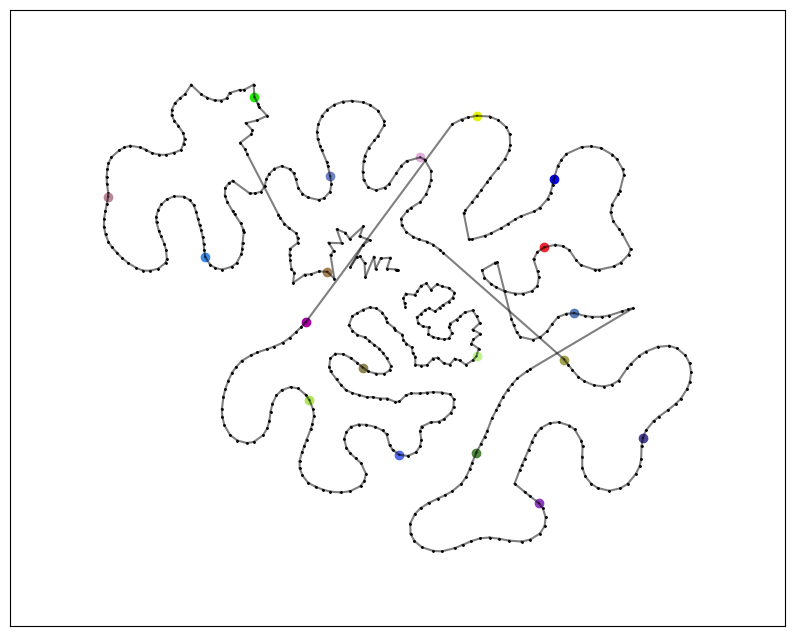

In [28]:
prev_center = []
# Plotting
plt.figure(figsize=(10, 8))

black = [0, 0, 0]

for idx in range(len(model_paths)):
    x = tsne_results[idx, 0]
    y = tsne_results[idx, 1]
    
    if idx in selected_models:
        plt.scatter(x, y, color=colors[idx])
    else:
        plt.scatter(x, y, s=1, color=black)
    
    # draw line to previous center
    if prev_center:
        # line
        plt.plot([prev_center[0], x], [prev_center[1], y], color=black, alpha=0.5)
    prev_center = [x, y]

    # Annotate the plot with the label at the centroid
    # if idx % 20 == 0:
    #     plt.annotate(f'Model {idx+1}', (centroid_x, centroid_y), fontsize=12)
    
# remove axis ticks
plt.xticks([])
plt.yticks([])

# get current x and y limits
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

r = 0.1
plt.xlim(x0 - r*(x1-x0), x1 + r*(x1-x0))
plt.ylim(y0 - r*(y1-y0), y1 + r*(y1-y0))
plt.show()

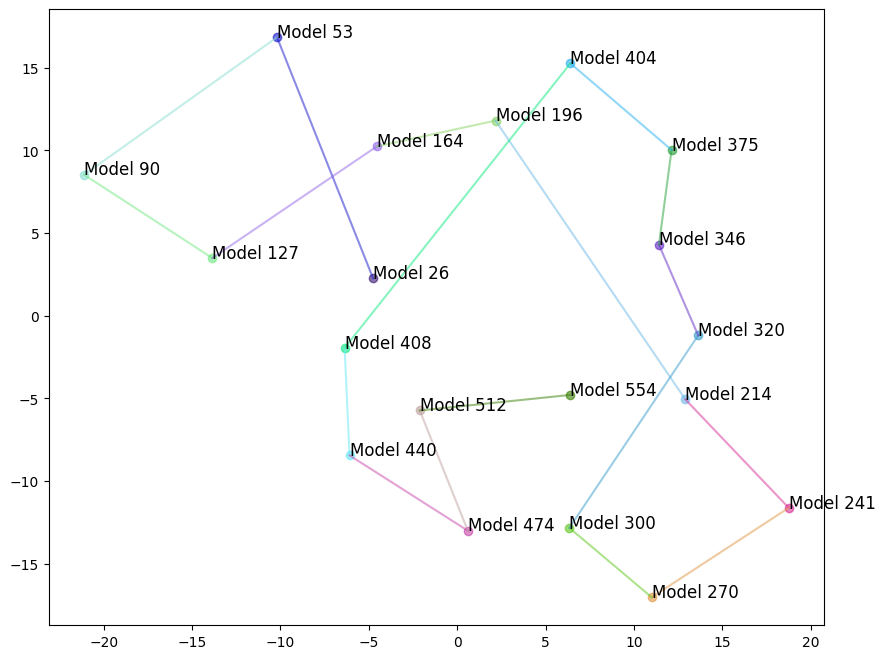

In [26]:
## draw the selected models
plt.figure(figsize=(10, 8))
prev_center = []
for idx in selected_models:
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                alpha=0.6, label=f'Model {idx+1}', color=colors[idx])

    # Calculate the centroid of the cluster
    centroid_x = np.mean(tsne_results[idx, 0])
    centroid_y = np.mean(tsne_results[idx, 1])
    
    # draw line to previous center
    if prev_center:
        # line
        plt.plot([prev_center[0], centroid_x], [prev_center[1], centroid_y], color=colors[idx], alpha=0.5)
    prev_center = [centroid_x, centroid_y]

    # Annotate the plot with the label at the centroid
    plt.annotate(f'Model {idx+1}', (centroid_x, centroid_y), fontsize=12)
plt.show()